## 获取数据

In [10]:
# 股票数据
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

                Open      High       Low     Close    Volume
Date                                                        
2020-01-02   67.4205   68.4340   67.3245   68.4340  27285300
2020-01-03   67.4000   68.6875   67.3660   68.0760  23412580
2020-01-06   67.5815   69.9160   67.5500   69.8905  46786860
2020-01-07   70.0230   70.1750   69.5780   69.7555  34529120
2020-01-08   69.7410   70.5925   69.6315   70.2520  35325480
...              ...       ...       ...       ...       ...
2023-12-22  140.7700  141.9900  140.7100  141.4900  26532199
2023-12-26  141.5900  142.6800  141.1900  141.5200  16780333
2023-12-27  141.5900  142.0800  139.8860  140.3700  19628618
2023-12-28  140.7800  141.1400  139.7500  140.2300  16045712
2023-12-29  139.6300  140.3600  138.7800  139.6900  18733017

[1006 rows x 5 columns]


In [ ]:
# 负荷数据
import pandas as pd
filename = 'data\electricity.csv'
df = pd.read_csv(filename).iloc[:1000,:]
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

## 输入输出

In [28]:
# mem_his_days=5
# per_days=10
# df.dropna(inplace=True)
# df.sort_index(inplace=True)

# df['label'] = df['Close'].shift(-per_days)
df.iloc[:,:]

,Open,High,Low,Close,Volume,label
Date,,,,,,
2020-01-02,67.4205,68.4340,67.3245,68.4340,27285300,72.5080
2020-01-03,67.4000,68.6875,67.3660,68.0760,23412580,73.9760
2020-01-06,67.5815,69.9160,67.5500,69.8905,46786860,74.1125
2020-01-07,70.0230,70.1750,69.5780,69.7555,34529120,74.2085
2020-01-08,69.7410,70.5925,69.6315,70.2520,35325480,74.2345
...,...,...,...,...,...,...
2023-12-22,140.7700,141.9900,140.7100,141.4900,26532199,NaN
2023-12-26,141.5900,142.6800,141.1900,141.5200,16780333,NaN
2023-12-27,141.5900,142.0800,139.8860,140.3700,19628618,NaN


In [11]:
# def stock_price_lstm_data_precesing(df,mem_his_days=5,per_days=10):

mem_his_days=5
per_days=10
# df.dropna(inplace=True)
# df.sort_index(inplace=True)

# 股票数据
df['label'] = df['Close'].shift(-per_days)
# 负荷数据
# df['label'] = df['OT'].shift(-per_days)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,1:-1])
# sca_X = np.array(df.iloc[:,:-1])
# print(sca_X)

from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))

X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

import numpy as np
X = np.array(X)
y = np.array(y)

    # return X,y,X_lately

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# sca_X = scaler.fit_transform(df.iloc[:,:-1])
# # sca_X = df.iloc[:,:-1]
# print(sca_X)

In [ ]:
# X,y,X_lately = stock_price_lstm_data_precesing(df,mem_his_days=5,per_days=50)

In [12]:
print(X.shape)
print(y.shape)
print(len(X_lately))

(992, 5, 4)
(992,)
10


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

# LSTM

## 参数寻优

In [ ]:
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dens_layers = [1,2,3]
# units = [8,16,32]
mem_days = [5]
lstm_layers = [1]
dens_layers = [1]
units = [32]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dens_layers in dens_layers:
            for the_units in units:
                # save model
                filepath = '{val_mape:.2f}_{epoch:02d}'+f'_mem_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dens_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)
                # print(filepath)
                X,y,X_lately = stock_price_lstm_data_precesing(df,mem_his_days=the_mem_days,per_days=10)
                from sklearn.model_selection import train_test_split
                X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.1)

                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                model = Sequential()
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                model.add(Dropout(0.1))
            
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))
                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))

                for i in range(the_dens_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))
                model.add(Dense(1))
                # model.summary()
                model.compile(optimizer='adam',loss='mse',metrics=['mape'])
                model.fit(X_train,y_train,batch_size=32,epochs=50,
                          validation_data=(X_test,y_test),
                          callbacks=[checkpoint])

                

## 构建网络

In [7]:
X.shape[1]

5

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
model = Sequential(name="lstm_m5_p10")
model.add(LSTM(32,input_shape=X.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.1))
# model.add(LSTM(32,activation='relu',return_sequences=True))
# model.add(Dropout(0.1))
model.add(LSTM(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

Model: "lstm_m5_p10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             4736      
_________________________________________________________________
dropout (Dropout)            (None, 5, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = 'save_model\\lstm'+'_val_mape{val_mape:.2f}_epoch{epoch:02d}_'+f'InputShape(None,{X.shape[1]},{X.shape[2]})'
checkpoint = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_mape',
    mode='min',
    save_best_only=True)
model.compile(optimizer='adam',loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[checkpoint])

Epoch 1/50
28/28 [==============================] - 2s 14ms/step - loss: 213.1714 - mape: 10.8531 - val_loss: 46.1815 - val_mape: 5.3571
INFO:tensorflow:Assets written to: save_model\lstm_val_mape5.36_epoch01_InputShape(None,5,4)\assets
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 172.5950 - mape: 9.4256 - val_loss: 54.2990 - val_mape: 5.8586
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 163.7933 - mape: 9.5855 - val_loss: 42.1721 - val_mape: 5.1944
INFO:tensorflow:Assets written to: save_model\lstm_val_mape5.19_epoch03_InputShape(None,5,4)\assets
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 163.7621 - mape: 9.5064 - val_loss: 42.2697 - val_mape: 5.2215
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 179.5928 - mape: 10.1164 - val_loss: 46.6872 - val_mape: 5.3864
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 168.4774 - mape: 9.2537 - val_loss: 49.0053 - val_

## 读取推理

In [4]:
from tensorflow.keras.models import load_model
best_model = load_model('save_model\lstm_val_mape4.85_epoch78_InputShape(None,5,4)')
best_model.summary()

Model: "lstm_m5_p10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             4736      
_________________________________________________________________
dropout (Dropout)            (None, 5, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 

In [5]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)
print(pre)

4/4 [==============================] - 0s 2ms/step - loss: 30.6223 - mape: 4.2894
[[131.83585 ]
 [ 77.50153 ]
 [ 90.78026 ]
 [134.1558  ]
 [ 88.47077 ]
 [ 77.21568 ]
 [ 73.95654 ]
 [141.89099 ]
 [ 68.37253 ]
 [104.95362 ]
 [134.5637  ]
 [139.6114  ]
 [133.09566 ]
 [106.49103 ]
 [136.77148 ]
 [126.23091 ]
 [ 57.131454]
 [135.22719 ]
 [ 76.36324 ]
 [137.57518 ]
 [ 75.42084 ]
 [ 88.10871 ]
 [120.757355]
 [ 77.34754 ]
 [104.66402 ]
 [130.527   ]
 [113.32001 ]
 [ 90.40673 ]
 [104.09762 ]
 [103.73765 ]
 [136.80542 ]
 [ 93.74878 ]
 [ 95.909386]
 [134.7048  ]
 [ 72.799126]
 [135.06519 ]
 [125.787735]
 [101.36174 ]
 [131.23651 ]
 [113.708496]
 [ 86.97899 ]
 [116.2118  ]
 [117.667755]
 [ 80.60627 ]
 [ 75.182594]
 [ 77.4966  ]
 [117.53791 ]
 [142.48434 ]
 [123.20145 ]
 [137.84195 ]
 [111.199875]
 [132.69751 ]
 [134.98036 ]
 [129.7346  ]
 [ 96.70679 ]
 [137.17357 ]
 [ 73.719604]
 [138.89862 ]
 [ 92.10805 ]
 [ 92.08603 ]
 [103.58015 ]
 [ 76.565414]
 [134.15771 ]
 [132.61638 ]
 [144.3738  ]
 [ 73.02

In [6]:
print(X_test.shape)
print(y_test.shape)
print(pre.shape)

(100, 5, 4)
(100,)
(100, 1)


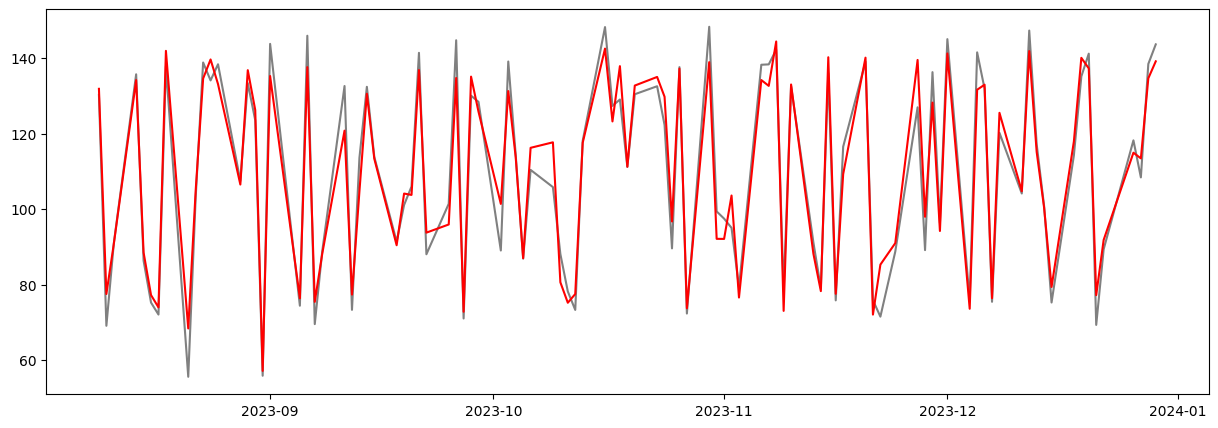

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,pre,color='red',label='predict')
plt.show()

In [18]:
X.shape

(992, 5, 4)

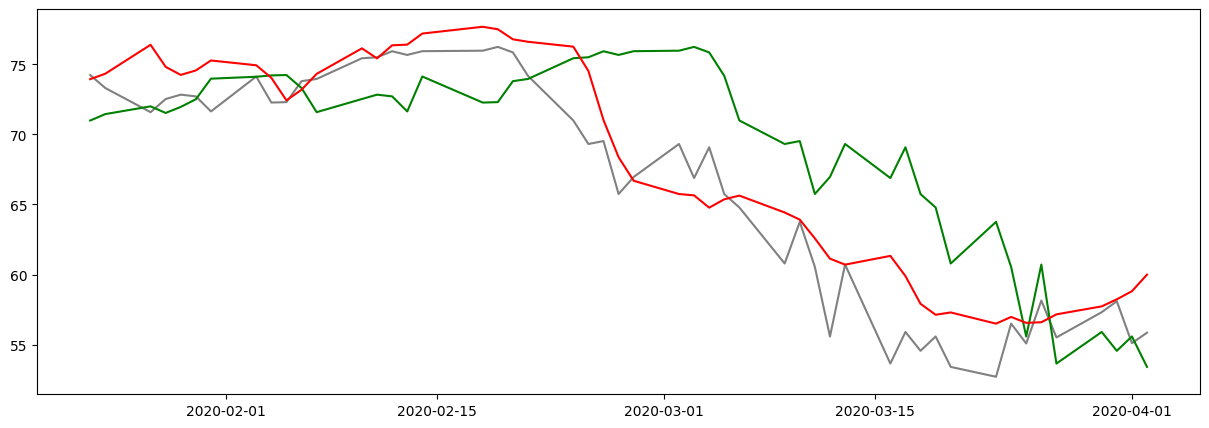

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y):]
show_len = np.arange(50)
plt.plot(df_time[show_len],y[show_len],color='gray',label='price')
plt.plot(df_time[show_len],df['Close'].values[show_len+5],color='green',label='price')
plt.plot(df_time[show_len],best_model.predict(X)[show_len+10],color='red',label='predict')
plt.show()

## pytorch

In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# 假设X_train, y_train, X_test, y_test已经是PyTorch张量格式
# X_train, y_train, X_test, y_test = ...

# 将数据转换为PyTorch的DataLoader
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义LSTM网络结构
class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.hidden_dim = 32
        self.num_layers = 3
        self.dropout = 0.1
        
        self.lstm1 = nn.LSTM(input_size=X_train.shape[1:], hidden_size=self.hidden_dim, 
                              num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.lstm2 = nn.LSTM(self.hidden_dim, self.hidden_dim, 
                              num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.lstm3 = nn.LSTM(self.hidden_dim, self.hidden_dim, 
                              num_layers=self.num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(self.hidden_dim, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # 通过第一个LSTM
        out, _ = self.lstm1(x)
        
        # 通过第二个LSTM
        out, _ = self.lstm2(out)
        
        # 通过第三个LSTM
        out, _ = self.lstm3(out)
        
        # 通过全连接层
        out = self.fc1(out[:, -1, :])
        out = torch.relu(out)
        out = self.fc2(out)
        
        return out

# 实例化网络
model = LSTMNet()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 在测试集上评估模型
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = model(inputs)
        # 这里可以计算MAPE或其他指标

# 进行预测
# pre = model(X_test)
# print(pre)

TypeError: empty(): argument 'size' must be tuple of SymInts, but found element of type tuple at pos 2

In [23]:
X_train_T,y_train_T = torch.tensor(X_train), torch.tensor(y_train)
X_test_T,y_test_T = torch.tensor(X_test), torch.tensor(y_test)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义PyTorch的LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出用于全连接层
        out = self.fc(out[:, -1, :])
        return out

# 假设X和y已经是PyTorch张量，且X已经reshape为(batch_size, seq_len, input_size)
input_size = X_train_T.shape[2]  # 特征数量
hidden_size = 32  # LSTM隐藏层的大小
num_layers = 3  # LSTM层的数量
output_size = 1  # 输出大小（对于回归任务）

# 实例化模型
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_T)
    loss = criterion(output, y_train_T.view(-1, 1))
    loss.backward()
    optimizer.step()

    # 打印每10个epoch的损失
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 评估模型
model.eval()
with torch.no_grad():
    y_pred = model(X_test_T)

# 计算MAPE
mape = torch.mean(torch.abs((y_pred - y_test_T) / y_test_T)) * 100

print(f'MAPE on test set: {mape.item():.4f}')

# 打印预测结果
print(y_pred)

RuntimeError: expected scalar type Double but found Float

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# 假设X_train, y_train, X_test, y_test是已经定义好的Numpy矩阵

# 将Numpy矩阵转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 定义PyTorch的LSTM模型
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 设置模型参数
input_dim = X_train_tensor.size(-1)  # 输入特征的维度
hidden_dim = 32  # LSTM隐藏单元的数量
num_layers = 3  # LSTM层的数量
output_dim = 1  # 输出的维度（对于回归问题）

# 实例化模型
model = LSTMNet(input_dim, hidden_dim, num_layers, output_dim)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-2)

# 定义学习率调度器，这里以StepLR为例，每30个epoch学习率减少到原来的0.1倍
scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

# # 将数据迁移到合适的设备上（CPU或GPU）
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# X_train_tensor = X_train_tensor.to(device)
# y_train_tensor = y_train_tensor.to(device)
# X_test_tensor = X_test_tensor.to(device)
# y_test_tensor = y_test_tensor.to(device)

# 训练模型
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    # 更新学习率
    scheduler.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 评估模型
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = y_pred.cpu().numpy()  # 将预测结果移回CPU并转换为Numpy数组

# 计算MAPE
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print(f'MAPE on test set: {mape:.4f}')

# 打印预测结果
print(y_pred)

Epoch [10/1000], Loss: 9713.4541
Epoch [20/1000], Loss: 7240.7266
Epoch [30/1000], Loss: 5206.0679
Epoch [40/1000], Loss: 3657.7556
Epoch [50/1000], Loss: 2543.6692
Epoch [60/1000], Loss: 1782.5413
Epoch [70/1000], Loss: 1289.1055
Epoch [80/1000], Loss: 986.3553
Epoch [90/1000], Loss: 811.2169
Epoch [100/1000], Loss: 716.1237
Epoch [110/1000], Loss: 667.9247
Epoch [120/1000], Loss: 645.2724
Epoch [130/1000], Loss: 635.4901
Epoch [140/1000], Loss: 631.6589
Epoch [150/1000], Loss: 630.3256
Epoch [160/1000], Loss: 629.9279
Epoch [170/1000], Loss: 629.8333
Epoch [180/1000], Loss: 629.8188
Epoch [190/1000], Loss: 629.8187
Epoch [200/1000], Loss: 629.8192
Epoch [210/1000], Loss: 629.8188
Epoch [220/1000], Loss: 629.8186
Epoch [230/1000], Loss: 629.8182
Epoch [240/1000], Loss: 629.8182
Epoch [250/1000], Loss: 629.8182
Epoch [260/1000], Loss: 629.8181
Epoch [270/1000], Loss: 629.8181
Epoch [280/1000], Loss: 629.8181
Epoch [290/1000], Loss: 629.8180
Epoch [300/1000], Loss: 629.8180
Epoch [310/1

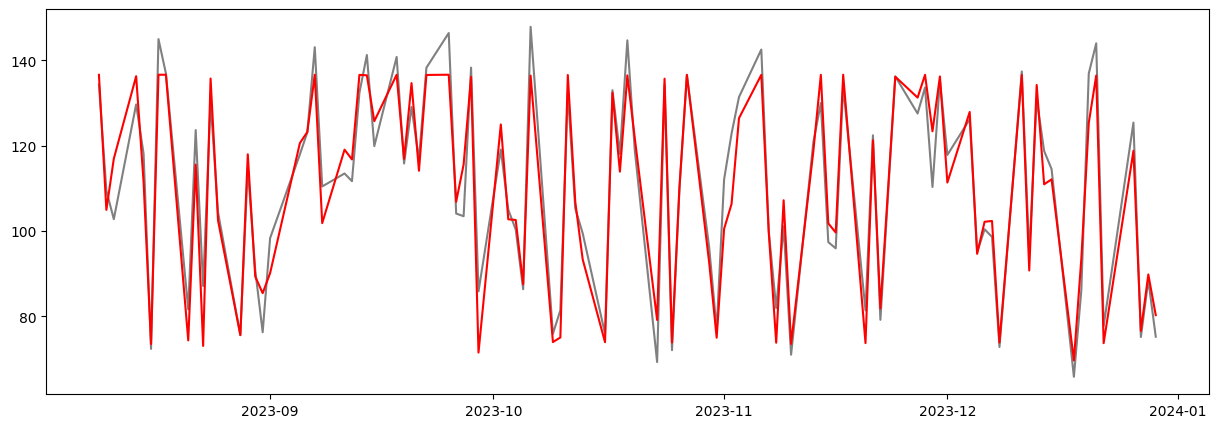

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# ENN

In [22]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense,Flatten

# 定义输入层
inputs = Input(shape=X_train.shape[1:])

# 定义前向的Dense层
dense1 = Dense(units=32, activation='relu')(inputs)

# 定义Elman网络层
rnn_layer = SimpleRNN(units=50, activation='tanh', return_sequences=True)(dense1)


flatten = Flatten()(rnn_layer)
# 定义后向的Dense层
outputs = Dense(units=1)(flatten)

# 创建模型
model = Model(inputs=inputs, outputs=outputs)
model.summary()



Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 4)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 5, 32)             160       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 5, 50)             4150      
_________________________________________________________________
flatten_1 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 251       
Total params: 4,561
Trainable params: 4,561
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
28/28 [==============================] - 1s 1ms/step - loss: 12372.5830
Epoch 2/50
28/28 [==============================] - 0s 1ms/step - loss: 10690.9102
Epoch 3/50
28/28 [==============================] - 0s 1ms/step - loss: 8765.9606
Epoch 4/50
28/28 [==============================] - 0s 1ms/step - loss: 7347.3592
Epoch 5/50
28/28 [==============================] - 0s 1ms/step - loss: 5961.1831
Epoch 6/50
28/28 [==============================] - 0s 1ms/step - loss: 4901.4779
Epoch 7/50
28/28 [==============================] - 0s 1ms/step - loss: 3992.6162
Epoch 8/50
28/28 [==============================] - 0s 1ms/step - loss: 3135.3106
Epoch 9/50
28/28 [==============================] - 0s 1ms/step - loss: 2606.3794
Epoch 10/50
28/28 [==============================] - 0s 1ms/step - loss: 2122.2835
Epoch 11/50
28/28 [==============================] - 0s 1ms/step - loss: 1732.9753
Epoch 12/50
28/28 [==============================] - 0s 1ms/step - loss: 1471.3182
Epoch 13/50

In [26]:
pre = model.predict(X_test)
print("Predicted output:", pre)

Predicted output: [[ 90.739815]
 [ 77.454704]
 [131.15201 ]
 [112.312256]
 [ 61.436863]
 [ 75.4239  ]
 [ 98.77575 ]
 [ 63.25077 ]
 [132.48145 ]
 [ 90.92006 ]
 [131.70193 ]
 [115.42574 ]
 [107.07034 ]
 [114.42076 ]
 [107.20005 ]
 [ 70.19975 ]
 [104.09124 ]
 [ 80.5336  ]
 [127.53572 ]
 [132.36172 ]
 [132.68832 ]
 [132.55229 ]
 [115.68047 ]
 [ 63.728996]
 [132.33308 ]
 [132.58829 ]
 [132.31618 ]
 [ 95.96984 ]
 [108.10305 ]
 [131.58699 ]
 [ 89.80625 ]
 [ 74.310005]
 [122.62157 ]
 [ 93.37064 ]
 [101.84384 ]
 [131.16277 ]
 [ 64.949875]
 [132.5234  ]
 [128.5874  ]
 [ 69.698235]
 [ 77.83694 ]
 [118.983086]
 [ 81.37314 ]
 [ 99.39062 ]
 [ 71.103584]
 [ 74.869675]
 [116.06686 ]
 [127.64628 ]
 [132.2362  ]
 [ 98.082146]
 [ 65.00717 ]
 [132.55208 ]
 [132.49796 ]
 [101.8223  ]
 [ 64.1434  ]
 [ 84.41531 ]
 [132.43463 ]
 [117.4743  ]
 [ 98.88211 ]
 [101.605606]
 [ 73.05081 ]
 [ 83.239555]
 [ 98.67373 ]
 [109.901535]
 [ 86.605064]
 [132.26942 ]
 [132.39848 ]
 [ 78.43644 ]
 [ 59.839252]
 [132.33844 ]
 [

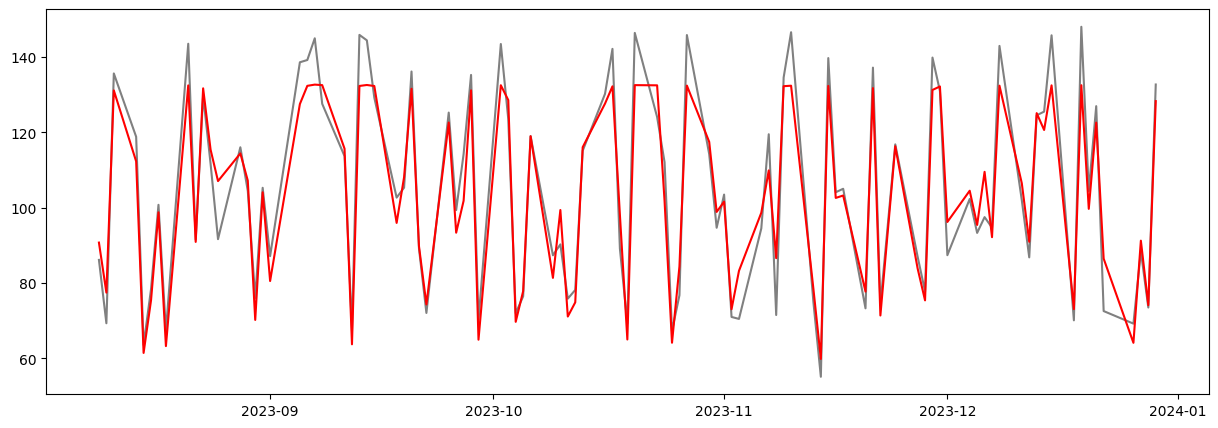

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,pre,color='red',label='predict')
plt.show()

# WNN

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class WaveletActivation(Layer):
    def __init__(self):
        super(WaveletActivation, self).__init__()

    def call(self, inputs):
        # Morlet Wavelet Activation Function
        return tf.cos(1.75 * inputs) * tf.exp(-inputs**2 / 2.0)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
import numpy as np

model = Sequential(name="WNN")
model.add(Dense(32, activation='relu', input_shape=X.shape[1:]))
model.add(Dropout(0.1))
model.add(WaveletActivation())
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

Model: "WNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 5, 32)             160       
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
wavelet_activation_2 (Wavele (None, 5, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                5152      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33      

In [14]:
model.compile(optimizer='adam', loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))


Epoch 1/50
28/28 [==============================] - 1s 6ms/step - loss: 10824.4691 - mape: 94.5105 - val_loss: 7905.7188 - val_mape: 80.1685
Epoch 2/50
28/28 [==============================] - 0s 2ms/step - loss: 7485.5190 - mape: 75.5296 - val_loss: 4456.7812 - val_mape: 56.3483
Epoch 3/50
28/28 [==============================] - 0s 2ms/step - loss: 3996.8279 - mape: 51.2220 - val_loss: 1859.6658 - val_mape: 31.0626
Epoch 4/50
28/28 [==============================] - 0s 5ms/step - loss: 1763.0442 - mape: 29.5155 - val_loss: 745.9081 - val_mape: 21.7645
Epoch 5/50
28/28 [==============================] - 0s 2ms/step - loss: 833.5231 - mape: 21.3153 - val_loss: 466.2368 - val_mape: 19.0135
Epoch 6/50
28/28 [==============================] - 0s 2ms/step - loss: 498.3588 - mape: 18.0882 - val_loss: 260.3501 - val_mape: 13.6838
Epoch 7/50
28/28 [==============================] - 0s 2ms/step - loss: 354.1207 - mape: 14.0830 - val_loss: 151.3644 - val_mape: 8.9167
Epoch 8/50
28/28 [=========

In [15]:
y_pred = model.predict(X_test)
print(y_pred)


[[ 97.259865]
 [128.82593 ]
 [ 73.04361 ]
 [ 74.96702 ]
 [138.20027 ]
 [ 89.6484  ]
 [135.05095 ]
 [ 59.392952]
 [101.557205]
 [136.1555  ]
 [128.63873 ]
 [115.51776 ]
 [107.203125]
 [114.69114 ]
 [101.022736]
 [121.19181 ]
 [129.34084 ]
 [121.42279 ]
 [136.07948 ]
 [130.40923 ]
 [121.43862 ]
 [ 73.603676]
 [137.98491 ]
 [ 79.00924 ]
 [ 68.52994 ]
 [ 84.98048 ]
 [ 89.28838 ]
 [ 60.55405 ]
 [106.33072 ]
 [104.474724]
 [ 73.52835 ]
 [108.3314  ]
 [ 73.57001 ]
 [137.3619  ]
 [ 78.23768 ]
 [121.93672 ]
 [136.82468 ]
 [135.32951 ]
 [ 73.37037 ]
 [ 97.095024]
 [ 54.54553 ]
 [139.35521 ]
 [139.39066 ]
 [138.75606 ]
 [117.55237 ]
 [117.92757 ]
 [ 91.80288 ]
 [112.20058 ]
 [ 74.195915]
 [130.77016 ]
 [133.35246 ]
 [ 72.78181 ]
 [114.61134 ]
 [ 71.05808 ]
 [108.25243 ]
 [109.34588 ]
 [ 77.26116 ]
 [125.42873 ]
 [ 86.81033 ]
 [129.70451 ]
 [ 90.0312  ]
 [130.85759 ]
 [136.08948 ]
 [ 95.672646]
 [106.59283 ]
 [134.83138 ]
 [108.71222 ]
 [100.92481 ]
 [133.74419 ]
 [135.57411 ]
 [ 96.83135 ]
 [117.

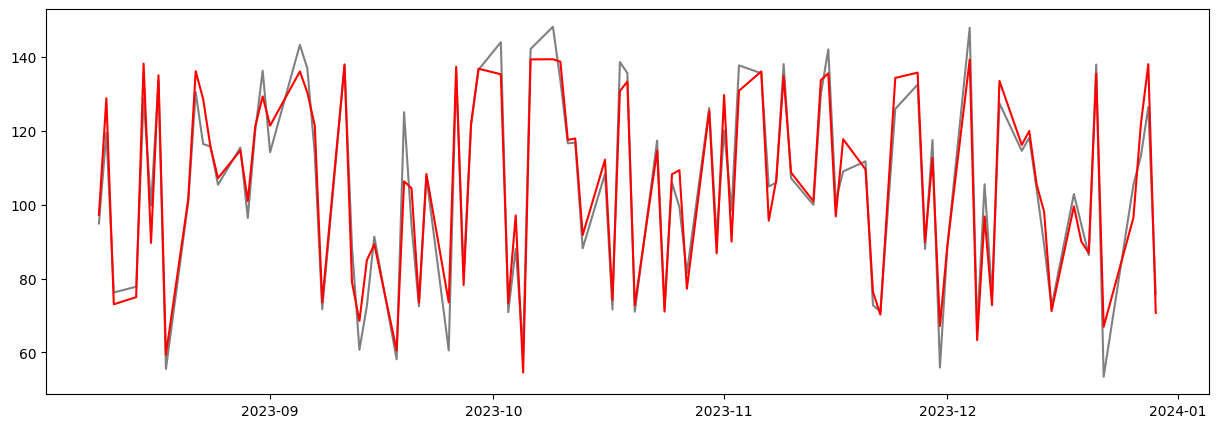

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# RBFNN


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomNormal

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        # 根据输入维度初始化中心点
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer=RandomNormal(),
                                       trainable=True)
        self.built = True

    def call(self, inputs):
        # 计算输入与中心点的欧氏距离的平方
        dist = tf.reduce_sum(tf.square(tf.expand_dims(inputs, 1) - self.centers), axis=2)
        # 应用 RBF 激活函数
        return tf.exp(-self.gamma * dist)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten

model = tf.keras.Sequential([
    RBFLayer(10, 0.5, input_shape=(1,)),
    tf.keras.layers.Dense(1)
])

model = Sequential(name="RBFNN")
model.add(Dense(32, activation='relu', input_shape=X.shape[1:]))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(RBFLayer(10, 0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

Model: "RBFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 5, 32)             160       
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
rbf_layer_10 (RBFLayer)      (None, 10)                1600      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                352       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33    

In [26]:
model.compile(optimizer='adam', loss='mse',metrics=['mape'])
model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))


Epoch 1/50
28/28 [==============================] - 1s 12ms/step - loss: 12450.1283 - mape: 99.9008 - val_loss: 11570.8438 - val_mape: 99.6590
Epoch 2/50
28/28 [==============================] - 0s 3ms/step - loss: 12510.2550 - mape: 99.5774 - val_loss: 11429.5674 - val_mape: 99.0540
Epoch 3/50
28/28 [==============================] - 0s 3ms/step - loss: 12088.6087 - mape: 98.8790 - val_loss: 11104.6436 - val_mape: 97.7218
Epoch 4/50
28/28 [==============================] - 0s 3ms/step - loss: 11650.7597 - mape: 97.2545 - val_loss: 10392.8604 - val_mape: 94.7539
Epoch 5/50
28/28 [==============================] - 0s 3ms/step - loss: 10913.5314 - mape: 93.4843 - val_loss: 9359.2383 - val_mape: 89.2467
Epoch 6/50
28/28 [==============================] - 0s 3ms/step - loss: 9734.3062 - mape: 87.5376 - val_loss: 8196.8223 - val_mape: 81.6963
Epoch 7/50
28/28 [==============================] - 0s 3ms/step - loss: 8608.0491 - mape: 80.9915 - val_loss: 7185.2061 - val_mape: 75.3699
Epoch 8/50

In [27]:
y_pred = model.predict(X_test)
print(y_pred)


[[101.86825 ]
 [124.51267 ]
 [ 75.338905]
 [ 77.2759  ]
 [132.00682 ]
 [ 91.35502 ]
 [129.39848 ]
 [ 63.436268]
 [103.00034 ]
 [130.40906 ]
 [124.2143  ]
 [117.29735 ]
 [110.11334 ]
 [115.82497 ]
 [104.59034 ]
 [121.75881 ]
 [129.5753  ]
 [118.267555]
 [130.65689 ]
 [127.853584]
 [118.70299 ]
 [ 72.97488 ]
 [131.67311 ]
 [ 82.24256 ]
 [ 72.98995 ]
 [ 86.49621 ]
 [ 91.184   ]
 [ 64.754906]
 [109.55154 ]
 [107.75985 ]
 [ 73.58232 ]
 [110.711235]
 [ 75.79717 ]
 [131.55476 ]
 [ 78.32924 ]
 [120.63476 ]
 [131.08125 ]
 [130.59036 ]
 [ 73.84597 ]
 [ 97.23933 ]
 [ 58.647118]
 [132.29662 ]
 [132.29662 ]
 [132.26988 ]
 [114.87149 ]
 [116.59625 ]
 [ 92.60879 ]
 [117.76899 ]
 [ 73.0042  ]
 [129.11652 ]
 [127.8148  ]
 [ 73.58403 ]
 [116.59399 ]
 [ 72.06052 ]
 [109.96377 ]
 [112.07648 ]
 [ 76.209915]
 [123.10418 ]
 [ 89.85299 ]
 [124.706215]
 [ 92.05844 ]
 [126.16999 ]
 [130.07094 ]
 [ 97.20985 ]
 [106.66444 ]
 [129.2348  ]
 [110.53983 ]
 [102.18183 ]
 [128.38818 ]
 [130.43639 ]
 [ 97.073074]
 [115.

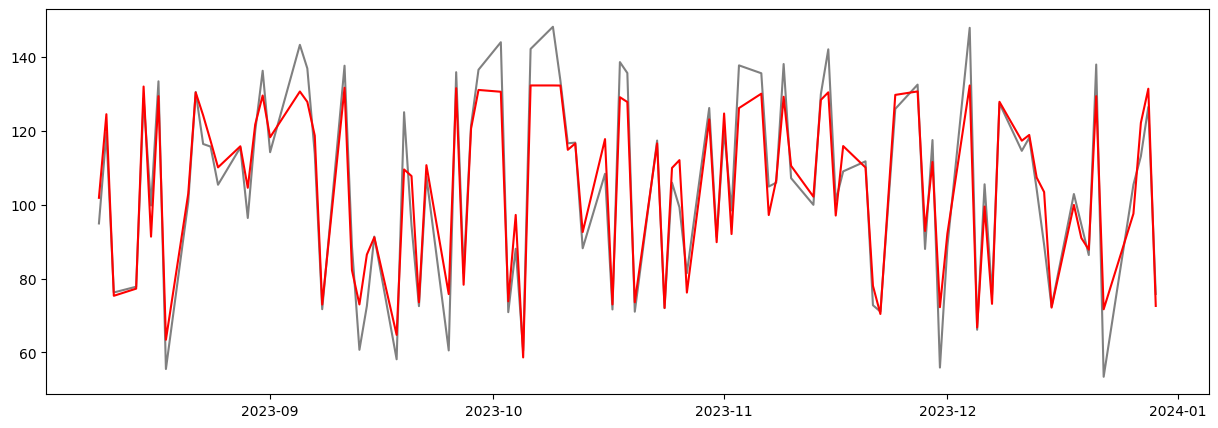

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# LS-SVM

In [18]:
from sklearn.model_selection import train_test_split
X_flattened = X.reshape(X.shape[0], -1)  # (样本数, 25)
X_train,X_test,y_train,y_test = train_test_split(X_flattened,y,test_size=0.1)

In [ ]:
X_flattened.shape

In [19]:
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 创建LS-SVM回归模型
# 创建LS-SVM回归模型，使用RBF核函数
model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))

In [20]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[134.68357373 123.39615161 119.90764949  86.9729601  102.77803641
 119.83525851  87.69623713 115.92698418 140.36104805  85.80769054
 138.64196955 129.04073355 123.04069114  84.85647829  78.75688581
 104.34524048 138.2447496  123.47985116  93.98676118 121.77913251
 107.10936768 133.81614943  68.54770874 117.37546103 139.1077301
  76.67513317 116.83063548  89.80081476 108.06332168 133.85033361
  77.35235963 136.02109716  84.08034604  85.38735443 136.48058569
 117.99956777  88.23696877 119.22817104 135.66878495 103.47158253
 138.60024938 135.56688109 117.81930686 108.72236859 118.88079687
  69.59660707 135.12406197  90.26898595 116.94600738 134.82492771
 135.95227194  99.33711451  82.29258867  78.31828265  76.29538443
  92.50167411 117.78340516 112.86719559  70.11509344 121.20567805
  99.0868725  112.95097136 123.5785255  139.48934706  76.33730974
 120.27836859 138.9524643  136.69573325 113.98294756  97.9654707
  72.78434984  80.64876989  72.02180584 133.64319903 139.21048781
 137.4718700

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

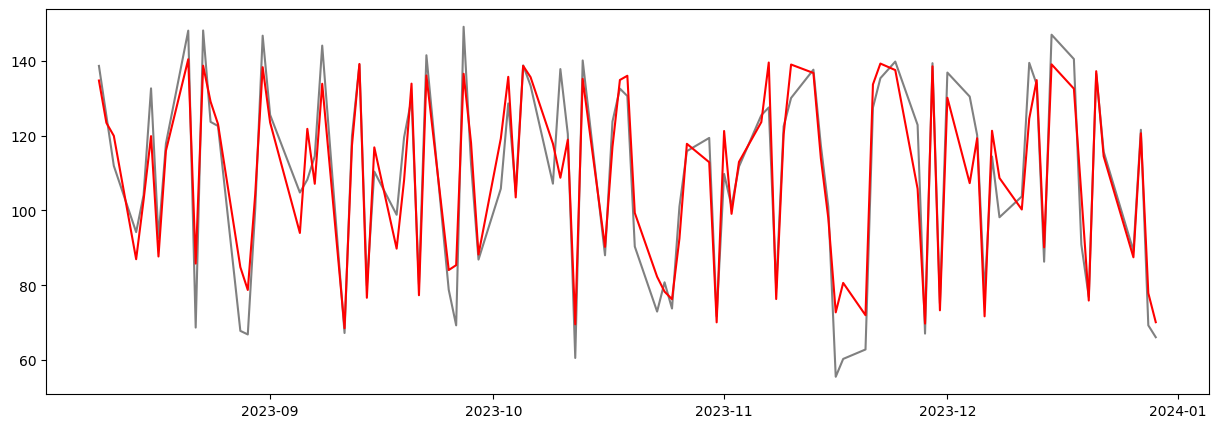

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

# KAN

In [21]:
import torch
import torch.nn as nn
import numpy as np

# 假设我们使用一个简化的激活函数作为样条曲线的替代
class SimplifiedSplineActivation(nn.Module):
    def __init__(self, in_features):
        super(SimplifiedSplineActivation, self).__init__()
        # 这里仅为示例，我们使用一个线性层来模拟可学习的激活函数
        self.linear = nn.Linear(in_features, in_features)
    
    def forward(self, x):
        return torch.tanh(self.linear(x))

# 定义一个简化版的KAN层
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(KANLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = SimplifiedSplineActivation(out_features)
    
    def forward(self, x):
        return self.activation(self.linear(x))

# 定义KAN网络
class KANNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(KANNetwork, self).__init__()
        self.layers = nn.ModuleList()
        in_features = input_size
        for size in hidden_sizes:
            self.layers.append(KANLayer(in_features, size))
            in_features = size
        self.layers.append(nn.Linear(in_features, output_size))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# 随机采样100个点来训练网络
x_train = np.random.rand(100, 1).astype(np.float32)
y_train = x_train ** 2  # 假设我们想要学习的是 x * 2 的关系

# 将数据转换为PyTorch张量
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)

# 创建网络
input_size = 1
hidden_sizes = [10, 10]  # 可以调整隐藏层的大小
output_size = 1
kan_net = KANNetwork(input_size, hidden_sizes, output_size)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(kan_net.parameters(), lr=0.001)

# 训练网络
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = kan_net(x_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# 测试网络
x_test = torch.tensor([[0.6]])
y_pred = kan_net(x_test)
print(f'Predicted value of y for x={x_test.item()} is: {y_pred.item()}')

Epoch 100/1000, Loss: 0.028784804046154022
Epoch 200/1000, Loss: 0.006932609714567661
Epoch 300/1000, Loss: 0.005489964969456196
Epoch 400/1000, Loss: 0.004219465423375368
Epoch 500/1000, Loss: 0.002862336114048958
Epoch 600/1000, Loss: 0.0014814111636951566
Epoch 700/1000, Loss: 0.0004997559008188546
Epoch 800/1000, Loss: 0.00011622958845691755
Epoch 900/1000, Loss: 4.0024518966674805e-05
Epoch 1000/1000, Loss: 3.1447267247131094e-05
Predicted value of y for x=0.6000000238418579 is: 0.35626184940338135


# SSM

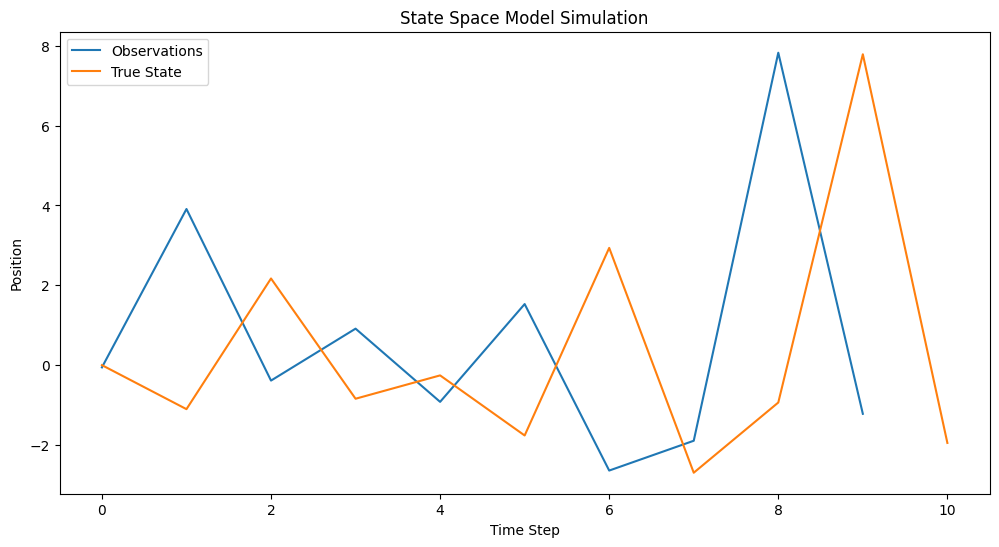

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# 定义时间步长
dt = 0.1

# 定义状态转移矩阵 A 和输入矩阵 B
A = np.array([[1.0, dt],
              [0.0, 1.0]])
B = np.array([[0.5 * dt**2],
              [dt]])

# 定义观测矩阵 C 和观测噪声矩阵 D
C = np.array([[1.0, 0.0]])
D = np.array([[0.0]])

# 定义初始状态和初始状态协方差
x0 = np.array([0.0, 0.0])
P0 = np.eye(2)

# 模拟过程，例如10个时间步长
num_steps = 10

# 用于存储状态和观测结果的列表
states = [x0]
observations = []

for t in range(num_steps):
    # 状态转移
    x = A @ x0 + np.random.multivariate_normal([0, 0], P0)
    states.append(x)
    
    # 观测
    y = C @ x + np.random.normal(0, 1)
    observations.append(y)
    
    # 更新状态协方差矩阵 P0（这里简化处理，实际应用中需要考虑预测和更新步骤）
    P0 = A @ P0 @ A.T + np.eye(2)

# 绘制状态和观测结果
plt.figure(figsize=(12, 6))
plt.plot(observations, label='Observations')
plt.plot([states[i][0] for i in range(num_steps + 1)], label='True State')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('State Space Model Simulation')
plt.show()

In [94]:
# Mamba
import numpy as np

class SSM:
    def __init__(self, state_dim, input_dim):
        self.A = np.eye(state_dim)  # 状态转移矩阵，可以设计为更复杂的结构
        self.B = np.zeros((state_dim, input_dim))  # 输入矩阵
        self.C = np.zeros((1, state_dim))  # 输出矩阵

    def forward(self, x):
        h = self.A @ x + self.B @ self.input  # 状态更新
        y = self.C @ h  # 输出计算
        return y, h

In [ ]:
class SelectiveSSM(SSM):
    def forward(self, x):
        # 根据输入数据x动态调整B和C
        self.B = self.update_B(x)
        self.C = self.update_C(x)
        
        # 执行状态更新和输出计算
        h = self.A @ x + self.B
        y = self.C @ h
        return y, h

    def update_B(self, x):
        # 示例：根据x更新B，实际实现可能更复杂
        return np.zeros_like(self.B) + x  # 这里仅为示例

    def update_C(self, x):
        # 示例：根据x更新C，实际实现可能更复杂
        return np.zeros_like(self.C) + x  # 这里仅为示例

In [ ]:
class MambaModel:
    def __init__(self, input_dim, hidden_dim, num_layers):
        self.layers = [SelectiveSSM(hidden_dim, input_dim) for _ in range(num_layers)]

    def forward(self, x):
        for layer in self.layers:
            x, _ = layer.forward(x)
        return x

In [ ]:
from torch import optim, nn

# 假设我们有一个训练数据集
train_data = ...

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mamba_model.parameters(), lr=0.001)

# 训练循环
for epoch in range(num_epochs):
    for x, y in train_data:
        optimizer.zero_grad()
        output = mamba_model.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")